In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys,os,caffe

In [2]:
caffe_root = '/home/chi/caffe/' 
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)
if not os.path.isfile(caffe_root + 'examples/cifar10/cifar10_quick_iter_4000.caffemodel.h5'):
    print("caffemodel is not exist...")

In [3]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'examples/cifar10/cifar10_quick.prototxt',
                caffe_root + 'examples/cifar10/cifar10_quick_iter_4000.caffemodel.h5',
                caffe.TEST)

In [4]:
net.blobs['data'].data.shape

(1, 3, 32, 32)

(240, 360, 3)


(-0.5, 359.5, 239.5, -0.5)

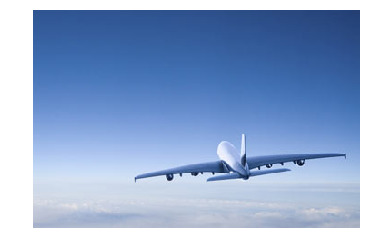

In [5]:
im = caffe.io.load_image('examples/images/airplanes.jpg')
print im.shape
plt.imshow(im)
plt.axis('off')

In [6]:
def convert_mean(binMean,npyMean):
    blob = caffe.proto.caffe_pb2.BlobProto()
    bin_mean = open(binMean, 'rb' ).read()
    blob.ParseFromString(bin_mean)
    arr = np.array( caffe.io.blobproto_to_array(blob) )
    npy_mean = arr[0]
    np.save(npyMean, npy_mean )
binMean=caffe_root+'examples/cifar10/mean.binaryproto'
npyMean=caffe_root+'examples/cifar10/mean.npy'
convert_mean(binMean,npyMean)

In [7]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(npyMean).mean(1).mean(1))
transformer.set_raw_scale('data', 255)  
transformer.set_channel_swap('data', (2,1,0))
net.blobs['data'].data[...] = transformer.preprocess('data',im)
inputData=net.blobs['data'].data

(-0.5, 31.5, 31.5, -0.5)

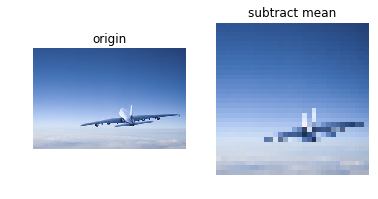

In [8]:
plt.figure()
plt.subplot(1,2,1),plt.title("origin")
plt.imshow(im)
plt.axis('off')
plt.subplot(1,2,2),plt.title("subtract mean")
plt.imshow(transformer.deprocess('data', inputData[0]))
plt.axis('off')

In [9]:
net.forward()
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 32, 32)),
 ('conv1', (1, 32, 32, 32)),
 ('pool1', (1, 32, 16, 16)),
 ('conv2', (1, 32, 16, 16)),
 ('pool2', (1, 32, 8, 8)),
 ('conv3', (1, 64, 8, 8)),
 ('pool3', (1, 64, 4, 4)),
 ('ip1', (1, 64)),
 ('ip2', (1, 10)),
 ('prob', (1, 10))]

In [10]:
def show_data(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    plt.axis('off')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

(1, 32, 32, 32)
(1, 32, 32, 32)
(32, 3, 5, 5)


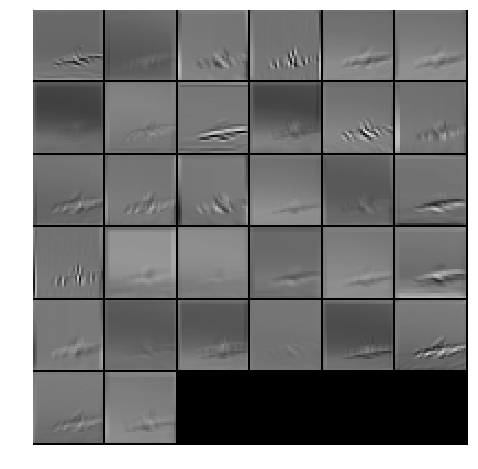

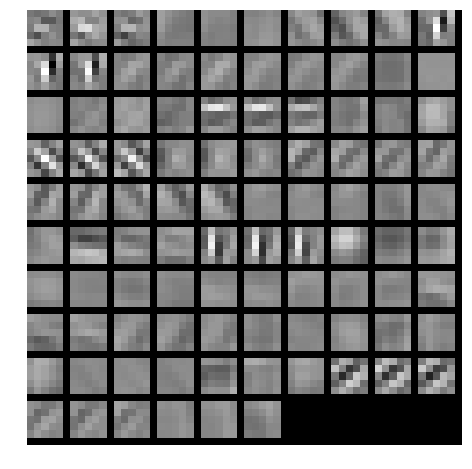

In [12]:
print(net.blobs['conv1'].data.shape)
show_data(net.blobs['conv1'].data[0])
print net.blobs['conv1'].data.shape
show_data(net.params['conv1'][0].data.reshape(32*3,5,5))
print net.params['conv1'][0].data.shape

(1, 64, 8, 8)
(64, 32, 5, 5)


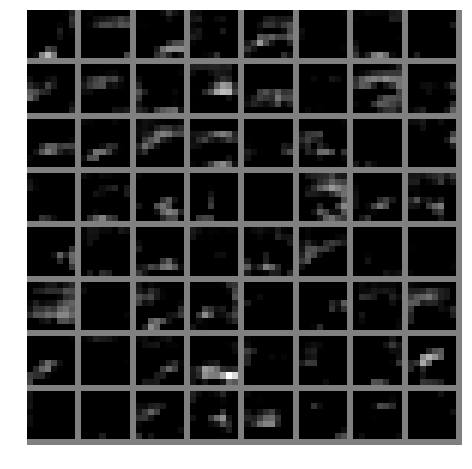

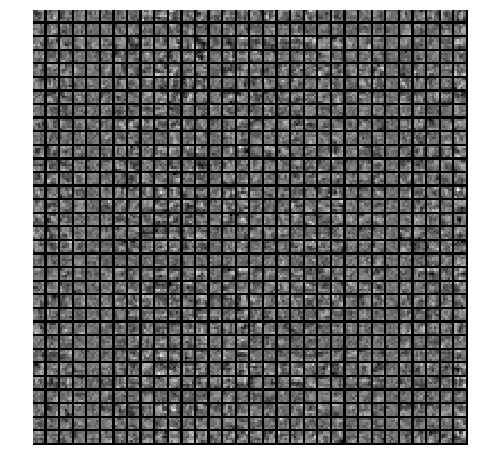

In [16]:
show_data(net.blobs['conv3'].data[0],padval=0.5)
print net.blobs['conv3'].data.shape
show_data(net.params['conv3'][0].data.reshape(64*32,5,5)[:1024])
print net.params['conv3'][0].data.shape

[  6.49180710e-01   7.86186138e-05   2.03397777e-02   2.89000213e-01
   9.16907005e-03   1.60837453e-02   8.98170564e-03   3.14814417e-04
   3.22701526e-03   3.62433353e-03]


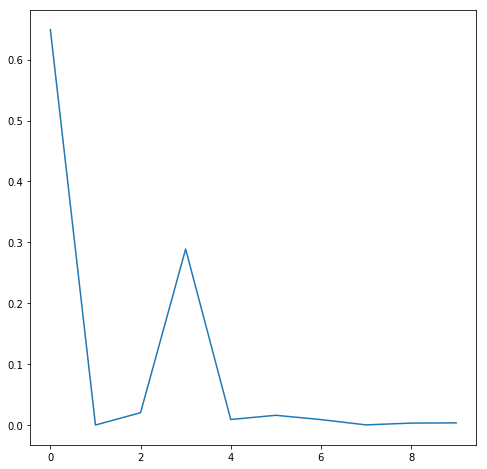

In [17]:
feat = net.blobs['prob'].data[0]
print feat
plt.plot(feat.flat)
# airplane、automobile、bird、cat、deer、dog、frog、horse、ship、truck